<a href="https://colab.research.google.com/github/Naomi-Ken-Korem/text-to-image-presentation/blob/main/Diffusion_models_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Models 
This notebook was created heavily realying on https://github.com/johnowhitaker/aiaiart 


We'll take a look at the core concept, implement a toy diffusion model ourselves, run through the modifications that have been added at different times to turn these into text-to-image systems, 



We'll also do a bit of a detour into what the *model* part of a diffusion model actually looks like in practice.



links to other resources relevant to all parts of this workshop:

AI Coffee Break - a very accessible video introduction to the topic: https://www.youtube.com/watch?v=344w5h24-h8

Denoising Diffusion Probabilistic Models: Paper (https://arxiv.org/abs/2006.11239) and blog post from the authors (https://hojonathanho.github.io/diffusion/)

Diffusion Models Beat GANs on Image Synthesis (Paper): https://arxiv.org/abs/2105.05233

DDPM - Diffusion Models Beat GANs on Image Synthesis (Machine Learning Research Paper Explained) - Yannic Kilcher on YouTube: https://www.youtube.com/watch?v=W-O7AZNzbzQ (and another video of his on GLIDE: https://www.youtube.com/watch?v=gwI6g1pBD84)

GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models. Paper from OpenAI (https://arxiv.org/abs/2112.10741) and code (https://github.com/openai/glide-text2im)
We will run this one also, in the next step

Dall-e2 paper (aka unCLIP, PDF): https://cdn.openai.com/papers/dall-e-2.pdf

Some key ideas came from people in the open-source community, like https://twitter.com/RiversHaveWings & https://twitter.com/jd_pressman. See a better list of cool peeps and extra info here: https://multimodal.art/




# Section 1: Overview of Diffusion Models

Let's begin by seeing where diffusion models fit within the zoo of generative models in use today:

The core concept behind these models is deceptively simple:
- Take a starting image
- Add some noise, iteratively degrading the image until almost nothing but noise remains. 
- Train a model to 'undo' these noise steps. 
- To generate, start from pure noise and repeatedly apply the model to 'denoise' our way back to a plausible image. 

The model generally has access to some representation of 't' - that is, how many noise steps have been applied to the image. And to make its job easier, we typically get the model to output a prediction for the *noise* that we could subtract from the noisy image to get a less noisy one, rather than spitting out the denoised image.

With this high-level idea in our heads, let's have a go at implementing one!


# Section 2: Implementing One




In [ ]:
# @title Install requirements
!pip install datasets &>> install.log
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#@title imports and utility functions
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


def img_to_tensor(im):
  im = im.resize((32,32))
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t) #similar to look up table, on a given dimenssion see https://pytorch.org/docs/stable/generated/torch.gather.html#torch.gather
    return c.reshape(-1, 1, 1, 1) #reshape to a tensor shape    




## 2.1 Dataset

We'll start with a classic faces dataset. For convenience we just pull a version that is avalable on the huggingface hub.

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/202599 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--CelebA-faces-8a807f0d7d4912ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

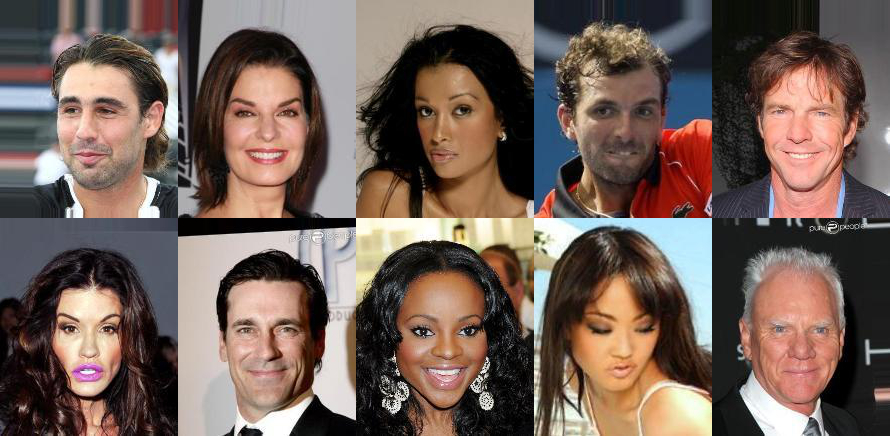

In [ ]:
# @title faces (CelebA) 

# Download and load the dataset
faces = load_dataset('huggan/CelebA-faces')
# View some examples:
image = Image.new('RGB', size=(178*5, 218*2))

for i in range(10):
  im = faces['train'][i]['image']
  image.paste(im, ( (i%5)*178, (i//5)*218 ))
image.resize((178*5, 218*2), Image.NEAREST)

## 2.2 Adding Noise

First, we want to define the step that adds a little bit of noise - $q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$:

![process](https://datasciencecastnethome.files.wordpress.com/2022/04/screenshot-from-2022-04-12-14-55-09.png) [(Image source)](https://hojonathanho.github.io/diffusion/)

We set up a 'variance schedule' β, where beta[t] ($\beta_t$)specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. The formula you'll see for this single noise step is:

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$

Scary! But not too bad once we break it down. We mix $\mathbf{x}_{t-1}$ with some gaussian noise, with how much noise decided by $\beta_t$. Let's see this in code and try applying it a bunch of times to an image:

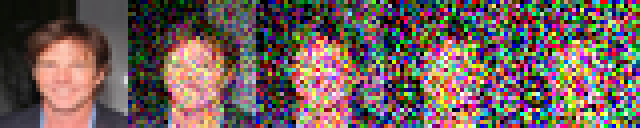

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1: torch.Tensor, t: torch.int64)-> torch.Tensor :
  mean = gather(1. - beta, t) ** 0.5 * xtm1 # √(1−βt)*xtm1
  var = gather(beta, t) # βt I
  eps = torch.randn_like(xtm1) # Noise shaped like xtm1
  return #HERE GOES YOUR CODE -return an example using the random noise, for the resulted gauusian distribution

# Show im at different stages
ims = []
start_im = faces['train'][4]['image']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))
  
  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor  

  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample from t=37. 

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$. 

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i$=1-$\beta_i$

Again, the code is far less scary:

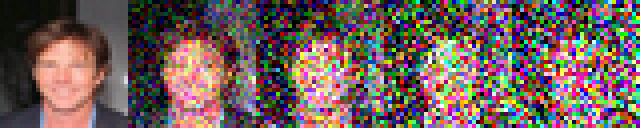

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0: torch.Tensor, t: torch.int64)-> torch.Tensor :
  mean =  # HERE GOES YOUR CODE  now with alpha_bar
  var = # HERE GOES YOUR CODE  (1-alpha_bar)
  eps = torch.randn_like(x0)
  return #HERE GOES YOUR CODE -return an example using the random noise, for the resulted gauusian distribution

# Show im at different stages
ims = []
start_im = faces['train'][4]['image']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Note the difference: we can now calculate xt without having to do `for t in range...`.

## 2.3 UNETs

So what model do we use to do this magical 'denoising' step? We can relay on basic convolutional neural networks that take in an image and output something like a classification. There are autoencoders that go from an image down to a latent representation and back to an output image. Those should be suitable

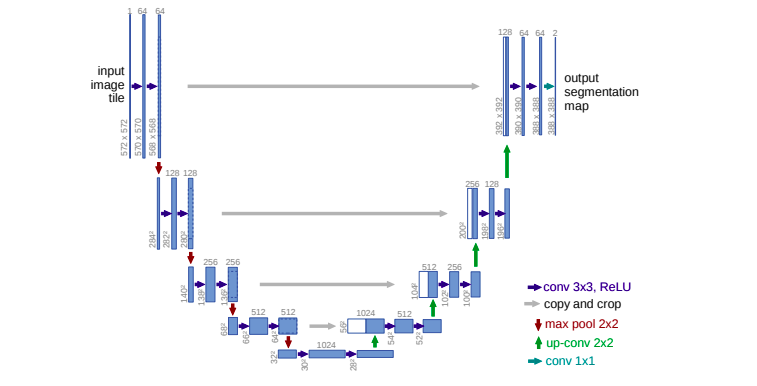

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottleneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers. 

These networks turned out to be great at all sorts of image-to-image tasks. Colorization ([deoldify](https://github.com/jantic/DeOldify)), segmentation and so on. These days, typical unet models incorporate ideas such as attention (it's all you need!) and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks. 

The implementation below (taken almost verbatim from [here](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/unet.py)) is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a look at the code and see if you can figure out roughly what's going on in the forward pass.



In [ ]:
#@title Unet Definition

import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# A fancy activation function
class Swish(nn.Module):
    """
    ### Swish actiavation function
    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding 
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # [same as those from the transformer](../../transformers/positional_encoding.html)
        #
        # \begin{align}
        # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
        # \end{align}
        #
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [ ]:
# Let's see it in action on dummy data:

# A dummy batch of 10 3-channel 32px images
x = torch.randn(10, 3, 32, 32)

# 't' - what timestep are we on
t = torch.tensor([50.], dtype=torch.long)

# Define the unet model
unet = UNet()

# The foreward pass (takes both x and t)
model_output = unet(x, t)

# The output shape matches the input.
model_output.shape

<ipython-input-10-5de78ba0795b>:7: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  t = torch.tensor([50.], dtype=torch.long)


torch.Size([10, 3, 32, 32])

## 2.4 Training Time

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly  due to convenience - the noise is nicely scaled with a mean of zero, and this well-suited to being modeled with a neural network, and it enables a faster sampling when running full inference. We can make it easy by tweaking our `q_xt_x0` function to return both the noised image ($x_t$) and the noise itself, which will be the 'target' our network tries to produce.

Training one epoch should take 15 minutes, but we are uisng only small set of the data to get some fast results. 
Here you see results of a model that was trained on the whole data.
For the current session, we will use only samll amount of the data, just to make it all run. To get better results just remove the "select" methid from the train data

In [ ]:
# Create the model
unet = UNet(n_channels=32).cuda()

# Set up some parameters
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):
  mean = #HERE GOES YOUR CODE with alpha_bar (same as in the above method)
  var = #HERE GOES YOUR CODE with alpha_bar (same as in the above method)
  eps = torch.randn_like(x0).to(x0.device)
  return #HERE GOES YOUR CODE with alpha_bar, return x_t and noise

# Training params
batch_size = 128 # Lower this if hitting memory issues
lr = 1e-4 # Explore this - might want it lower when training on the full dataset

losses = [] # Store losses for later plotting

dataset = faces['train'].select(range(30000)) # to use a 30k subset for demo 



In [ ]:
optim = torch.optim.AdamW(unet.parameters(), lr=lr) # Optimizer
for i in tqdm(range(0, len(dataset)-batch_size, batch_size)): # Run through the dataset
  ims = [dataset[idx]['image'] for idx in range(i,i+batch_size)] # Fetch some images
  tims = [img_to_tensor(im).cuda() for im in ims] # Convert to tensors
  x0 = torch.cat(tims) # Combine into a batch
  t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda() # Random 't's 
  xt, noise = q_xt_x0(x0, t) # Get the noised images (xt) and the noise (our target)
  pred_noise = unet(xt.float(), t) # Run xt through the network to get its predictions
  loss = F.mse_loss(noise.float(), pred_noise) # Compare the predictions with the targets
  losses.append(loss.item()) # Store the loss for later viewing
  optim.zero_grad() # Zero the gradients
  loss.backward() # Backpropagate the loss (computes and store gradients)
  optim.step() # Update the network parameters (using those gradients)
  state_dict = unet.state_dict()


  0%|          | 0/1582 [00:00<?, ?it/s]

  0%|          | 0/1582 [00:00<?, ?it/s]

  0%|          | 0/1582 [00:00<?, ?it/s]

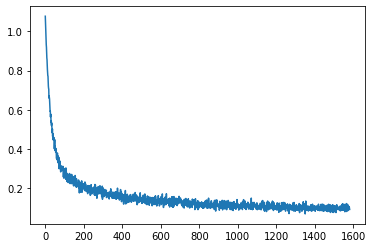

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

## 2.5 The Reverse Step

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$. But this is in fact intercatable. We can predict $\mathbf{x}_{t-1}$ in case we know $\mathbf{x}_{0}$. 
$q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_{0}) = \mathcal{N}(\mu(\mathbf{x}_{t}, \mathbf{x}_{0}), \widetilde{\beta}_{t}\mathbf{I})$
But $\mathbf{x}_{0}$ is unknown.

Thus we need to use a model that learns the distribution.

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that (hopefully) looks like a real image.

So, how can we get $\mathbf{x}_{t-1}$?

First lets difine predicted $\mathbf{x}_{0-pred}$:

Since $\mathbf{x}_{t} = \sqrt{\bar{\alpha}_t} \mathbf{x}_{0} +  \sqrt{(1 - \bar{\alpha}_t)}noise$ 

and the model is trained to predict the noise, we get that

$\mathbf{x}_{0-pred} = \frac{\mathbf{x}_{t} - \sqrt{(1 - \bar{\alpha}_{t})}noise_{pred}}{\sqrt{\bar{\alpha}_t}}$

Now we can find $\mathbf{x}_{t-1}$: (https://arxiv.org/pdf/2006.11239.pdf equation 7)
$\mathbf{x}_{t-1} = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_{t}}{{(1 - \bar{\alpha}_t)}}\mathbf{x}_{0-pred} + \frac{\sqrt{\bar{\alpha}_t}(1 - \bar{\alpha}_{t-1})}{(1 - \bar{\alpha}_{t})}\mathbf{x}_{t} + \sqrt{\frac{(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_{t}}\beta_{t}}\mathbf{I}$

Note that you run a very short training, so you won't get good results. To get better results train on the whole dataset, for couple of epochs.



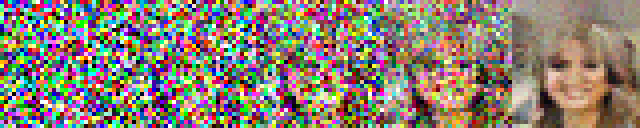

In [ ]:
# # import torch
def p_xt(xt, noise, t):
  "predict x(t-1) given x(t)"

  alpha_t = gather(alpha.to(xt.device), t)
  beta_t = 1 - alpha_t
  alpha_bar_t = gather(alpha_bar.to(xt.device), t)
  beta_prod_t = 1 - alpha_bar_t


  alpha_bar_t_prev = gather(alpha_bar.to(xt.device), t-1) if t >=1 else torch.tensor(1.0).to(xt.device)
  beta_prod_t_prev = 1 - alpha_bar_t_prev

  x_0_pred = #HERE GOES YOUR CODE
  
  pred_original_sample_coeff = (alpha_bar_t_prev ** (0.5) * beta_t) / beta_prod_t
  current_sample_coeff = alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

        
  pred_prev_sample = #HERE GOES YOUR CODE
  var = gather(beta.to(xt.device), t)
  eps = torch.randn(xt.shape, device=xt.device)
  return pred_prev_sample + var **.5 * eps



x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))
    if i%24 == 0:
      ims.append(tensor_to_image(x.cpu()))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Lets check DDIM Ordenary sampling.
Same as the previous sampling, but no noise is added to sampeled mean.

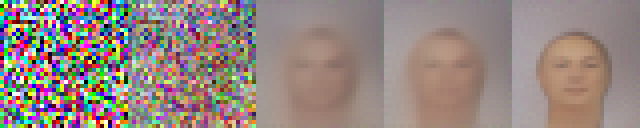

In [ ]:
def p_xt_ddim(xt, noise, t):
  "predict x(t-1) given x(t)"

  alpha_t = gather(alpha.to(xt.device), t)
  beta_t = 1 - alpha_t
  alpha_bar_t = gather(alpha_bar.to(xt.device), t)
  beta_prod_t = 1 - alpha_bar_t


  alpha_bar_t_prev = gather(alpha_bar.to(xt.device), t-1) if t >=1 else torch.tensor(1.0).to(xt.device)
  beta_prod_t_prev = 1 - alpha_bar_t_prev

  x_0_pred = (1/alpha_bar_t)**.5 * xt - (1.0 / alpha_bar_t - 1)**.5 * noise
  
  pred_original_sample_coeff = (alpha_bar_t_prev ** (0.5) * beta_t) / beta_prod_t
  current_sample_coeff = alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

        
  pred_prev_sample = #HERE GOES YOUR CODE

  return pred_prev_sample

x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt_ddim(x, pred_noise, t.unsqueeze(0))
    if i%24 == 0:
      ims.append(tensor_to_image(x.cpu()))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Perfect? No... Oh well, let's try a few more times:

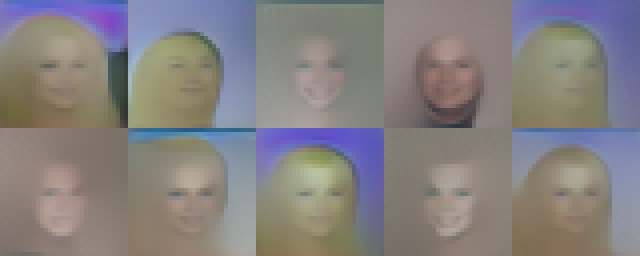

In [ ]:
#@title Make and show 10 examples:
x = torch.randn(10, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt_ddim(x, pred_noise, t.unsqueeze(0))

for i in range(10):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
image.resize((32*4*5, 32*4*2), Image.NEAREST)

We're only training here with 100 noise steps, and perhaps the model mostly sees images with at least a little bit of structure to them. If we start with a half-noised image can it at least 'fix' it back to something like the original?

torch.Size([10, 3, 32, 32])


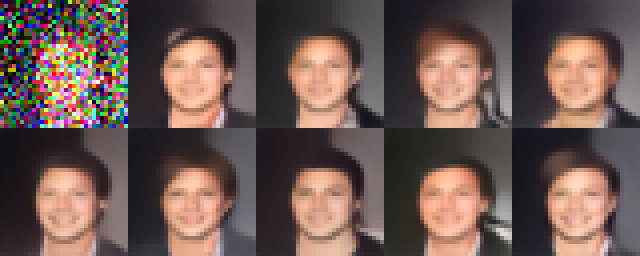

In [ ]:
#@title Start with a heavily noised image (t=50, top left = starting point):
face = faces['train'][4]['image']
x0 = img_to_tensor(face)
x = torch.cat([q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0] for _ in range(10)] )
example_start = q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0]
print(x.shape)
ims = []
for i in range(50, n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda().unsqueeze(0)
  with torch.no_grad():
    pred_noise = unet(x.float(), t)
    x = p_xt_ddim(x, pred_noise, t)

for i in range(10):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
  if i==0:image.paste(tensor_to_image(example_start.unsqueeze(0).cpu()), ((i%5)*32, 32*(i//5))) # Show the heavily noised starting point top left
image.resize((32*4*5, 32*4*2), Image.NEAREST)